In [11]:
import sys
sys.path.append(r'../scripts')

import numpy as np
import random
import os
import pandas as pd
import pickle

import matplotlib.pyplot as plt

from ElMD import ElMD
from ElM2D import ElM2D
from scipy.spatial.distance import squareform
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.cluster import DBSCAN

from data_featurization import (load_data, load_cif_structure, get_normalized_formula, get_el2md_mapper)

import warnings
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_pandas

warnings.filterwarnings("ignore")
tqdm_pandas.pandas()

seed = 42
np.random.seed(seed)
random.seed(seed)

### Define paths for relevant directories

In [4]:
labelled_conductivity_database_path = r"..\data\ionic_conductivity_database_11022023_wo_duplicates.csv"
icsd_li_cifs_path = r"..\data\icsd_li_cifs"

output_dir = r"data"

### Load Pymatgen structures and get normalized formula for each

In [5]:
labelled_conductivity_database = load_data(labelled_conductivity_database_path)
labelled_conductivity_database['structure'] = labelled_conductivity_database['icsd_collectioncode'].progress_apply(load_cif_structure, cif_dir=icsd_li_cifs_path)
labelled_conductivity_database['normalized_formula'] = labelled_conductivity_database['structure'].progress_apply(lambda x: get_normalized_formula(x))

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

### Construct El2MD mapper with normalized formulas

In [47]:
mapper = ElM2D()
formula_list = list(set(labelled_conductivity_database['normalized_formula']))
X_ump = mapper.fit_transform(formula_list)

Fitting mod_petti kernel matrix
Constructing distances
Parsing Formula


100%|██████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 9466.20it/s]


Constructing joint compositional pairings


100%|█████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 36042.27it/s]

Creating Process Pool
Scattering compositions between processes and computing distances


  0%|          | 0/511 [00:00<?, ?it/s]

Distances computed closing processes
Flattening sublists
Constructing UMAP Embedding to 2 dimensions


In [6]:
output_file_path = os.path.join(output_dir, "cluster_mapper.pkl")
print(output_file_path)
#if not os.path.exists(output_dir):
#    os.makedirs(output_dir)
#with open(output_file_path, "wb") as f:
#    pickle.dump(mapper, f)

data\cluster_mapper.pkl


### Construct clusters and save

In [9]:
with open(r"..\data\cluster_mapper.pkl", 'rb') as f:
    mapper = pickle.load(f)
mapper.umap_kwargs = {"random_state": 1, "n_components": 2, "spread": 5}
X_ump = mapper.transform()
X_ump_db = []
for formula in labelled_conductivity_database['normalized_formula'].to_list():
    index = mapper.formula_list.index(formula)
    X_ump_db.append(X_ump[index, :])
X_ump_db = np.array(X_ump_db)
clf = DBSCAN(eps=4)
lab = clf.fit_predict(X_ump_db)
labelled_conductivity_database['cluster'] = lab

Constructing UMAP Embedding to 2 dimensions


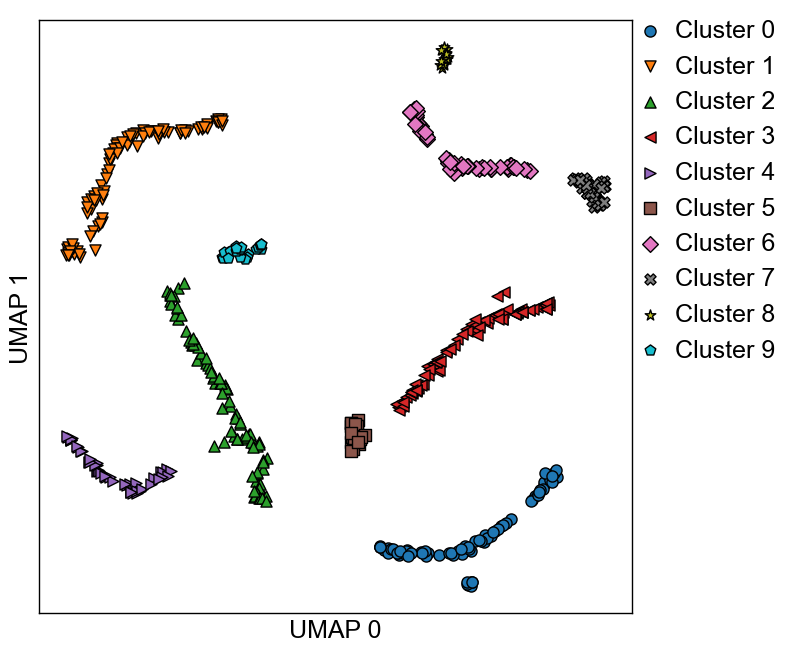

In [15]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1
fig, ax = plt.subplots(figsize=(8, 8))

markers = ['o', 'v', '^', '<', '>', 's', 'D', 'X', '*', 'p']
cmap = plt.cm.tab10

for i, label in enumerate(np.unique(lab)):
    mask = lab == label
    ax.scatter(-X_ump_db[mask, 0], 
               X_ump_db[mask, 1],
               label=f'Cluster {label}', 
               marker=markers[i % len(markers)],  # Cycle through markers
               c=cmap.colors[i],
               s=64,
               edgecolors='k'
              )

ax.legend(fontsize=18, frameon=False, handletextpad=0.01, bbox_to_anchor=(0.95, 1.04), loc='upper left')

ax.set_xticks([])
ax.set_yticks([])

plt.xlabel('UMAP 0', fontsize=18)
plt.ylabel('UMAP 1', fontsize=18)

ax.set_aspect(np.diff(ax.get_xlim()) / np.diff(ax.get_ylim()))

plt.tight_layout()
plt.savefig(r'..\figures\UMAP_clustering.png', dpi=450, bbox_inches='tight')
plt.show()

In [66]:
csv_columns = [col for col in labelled_conductivity_database.columns if col not in ["structure", "ordered_structure_wo_Li"]]
labelled_conductivity_database[csv_columns].to_csv('..\data\ionic_conductivity_database_11022023_wo_duplicates_wclusters.csv', index=False)

### Generate Training, Validation, and Testing splits for K-fold validation and LOCO-CV

In [3]:
labelled_conductivity_database = load_data(r'..\data\ionic_conductivity_database_11022023_wo_duplicates_wclusters.csv')

In [7]:
X_train_val, X_test = train_test_split(labelled_conductivity_database, test_size=0.10, random_state=seed)

test_output_dir = '..\data\ionic_conductivity_database_11022023_train_val_test_splits\classification\test'
if not os.path.exists(test_output_dir):
    os.makedirs(test_output_dir)
    
X_test.to_csv(os.path.join(test_output_dir, 'test.csv'), index=False)

In [8]:
n_splits = 5

kf_classification = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
for i, (train_index, val_index) in enumerate(kf_classification.split(X_train_val, X_train_val['is_superionic'])):
    
    train_fold = X_train_val.iloc[train_index]
    val_fold = X_train_val.iloc[val_index]
    
    os.makedirs(f'..\data\ionic_conductivity_database_11022023_train_val_test_splits\classification\kfold\fold_{i}', exist_ok=True)
    train_fold.to_csv(f'..\data\ionic_conductivity_database_11022023_train_val_test_splits\classification\kfold\fold_{i}\train.csv', index=False)
    val_fold.to_csv(f'..\data\ionic_conductivity_database_11022023_train_val_test_splits\classification\kfold\fold_{i}\val.csv', index=False)

In [10]:
clusters = labelled_conductivity_database['cluster'].unique()

for validation_cluster in clusters:

    output_dir_filepath_classification = f'..\data\ionic_conductivity_database_11022023_train_val_test_splits/classification/lococv/fold_{validation_cluster}'
    os.makedirs(output_dir_filepath_classification, exist_ok=True)

    validation_fold_classification = X_train_val[X_train_val['cluster'] == validation_cluster]
    validation_fold_classification.to_csv(os.path.join(output_dir_filepath_classification, 'val.csv'), index=False)
    
    training_clusters = [cluster for cluster in clusters if cluster != validation_cluster]

    training_fold_classification = X_train_val[X_train_val['cluster'].isin(training_clusters)]
    training_fold_classification.to_csv(os.path.join(output_dir_filepath_classification, 'train.csv'), index=False)

### Calculate statistics for the test, training, and validation folds

In [62]:
def summarize_statistics(df):
    summary = {
        'Num_entries': len(df),
        'Max_log10sigma': df['log10conductivity'].max(),
        'Min_log10sigma': df['log10conductivity'].min(),
        'Mean_log10sigma': df['log10conductivity'].mean(),
        'Num_positive_samples': len(df[df['is_superionic'] == 1]),
        'Num_negative_samples': len(df[df['is_superionic'] == 0]),
        'Fraction_positive_samples': len(df[df['is_superionic'] == 1]) / len(df),
    }
    return summary

test_dir = r"..\data\ionic_conductivity_database_11022023_train_val_test_splits\classification\test"
train_val_dir = validation_dir = r"..\data\ionic_conductivity_database_11022023_train_val_test_splits\classification\kfold\fold_0"

test_path = os.path.join(test_dir, 'test.csv')
train_path = os.path.join(train_val_dir, 'train.csv')
val_path = os.path.join(train_val_dir, 'val.csv')

test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

train_val_df = pd.concat([train_df, val_df], axis=0)

test_summary = summarize_statistics(test_df)
train_val_summary = summarize_statistics(train_val_df)

summaries = {}

summaries['Test'] = test_summary
summaries['Training and Validation'] = train_val_summary

summary_df = pd.DataFrame.from_dict(summaries, orient='index')
summary_df.index.name = 'Split'

output_path = "summary_statistics_test.csv"
summary_df.to_csv(output_path)

In [63]:
summaries = {}

validation_dir = r"..\data\ionic_conductivity_database_11022023_train_val_test_splits\classification\lococv"
for fold_dir in os.listdir(validation_dir):
    if fold_dir.startswith('fold_'):
        train_path = os.path.join(validation_dir, fold_dir, 'train.csv')
        val_path = os.path.join(validation_dir, fold_dir, 'val.csv')
        if os.path.exists(train_path) and os.path.exists(val_path):
            train_df = pd.read_csv(train_path)
            val_df = pd.read_csv(val_path)
                
            train_summary = summarize_statistics(train_df)
            val_summary = summarize_statistics(val_df)
            fold_num = fold_dir.split("_")[-1]
            
            summaries[(fold_num, 'Train')] = train_summary
            summaries[(fold_num, 'Validation')] = val_summary
summary_df = pd.DataFrame.from_dict(summaries, orient='index')
summary_df.index = pd.MultiIndex.from_tuples(summary_df.index, names=['Validation Fold', 'Set'])

output_path = "..\data\summary_statistics_lococv.csv"
summary_df.to_csv(output_path)

In [64]:
summaries = {}

validation_dir = r"..\data\ionic_conductivity_database_11022023_train_val_test_splits\classification\kfold"
for fold_dir in os.listdir(validation_dir):
    if fold_dir.startswith('fold_'):
        train_path = os.path.join(validation_dir, fold_dir, 'train.csv')
        val_path = os.path.join(validation_dir, fold_dir, 'val.csv')
        if os.path.exists(train_path) and os.path.exists(val_path):
            train_df = pd.read_csv(train_path)
            val_df = pd.read_csv(val_path)
                
            train_summary = summarize_statistics(train_df)
            val_summary = summarize_statistics(val_df)
            fold_num = fold_dir.split("_")[-1]
            
            summaries[(fold_num, 'Train')] = train_summary
            summaries[(fold_num, 'Validation')] = val_summary
summary_df = pd.DataFrame.from_dict(summaries, orient='index')
summary_df.index = pd.MultiIndex.from_tuples(summary_df.index, names=['Validation Fold', 'Set'])

output_path = "..\data\summary_statistics_kfold.csv"
summary_df.to_csv(output_path)